In [21]:
using LazySets, Plots

In [73]:
A = rand(Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.1924979214176801, -0.2958918702884322], [0.5284181902250101, 1.3287940096980675])

In [74]:
B = rand(2, 2) * A

LinearMap{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,2}}([0.2043004014879526 0.6277925727053268; 0.6985030692990073 0.02731384557034211], Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.1924979214176801, -0.2958918702884322], [0.5284181902250101, 1.3287940096980675]))

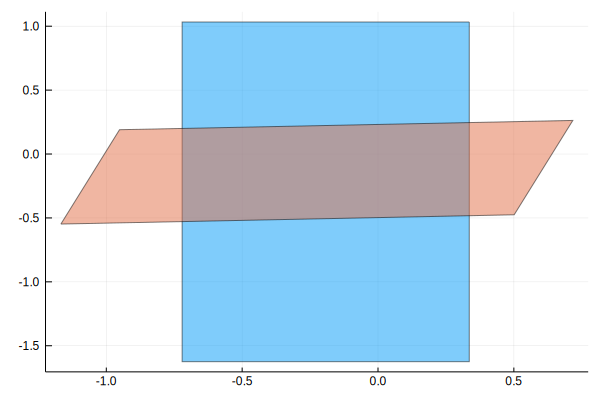

In [75]:
plot([A, B])

In [76]:
C = intersection(A, B)

HPolytope{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([0.04346663511624247, -0.999054879189162], 0.4966842736281392), HalfSpace{Float64,Array{Float64,1}}([-0.04346663511624247, 0.999054879189162], 0.23143651808441273), HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0], 0.33592026880733006), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.7209161116426902)])

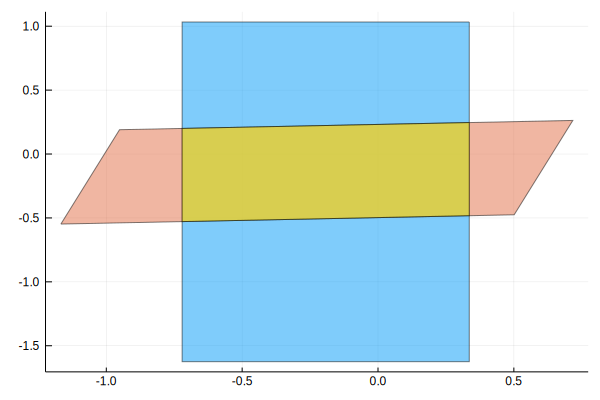

In [77]:
plot!(ans, color=:yellow)

In [78]:
# naive implementation for the polygon area using
# Shoelace formula, cf. https://en.wikipedia.org/wiki/Shoelace_formula
# This is: https://github.com/JuliaReach/LazySets.jl/issues/2055
function area(X::LazySet{N}) where {N}
    @assert dim(X) == 2 "this function only applies to two-dimensional sets, " *
    "but the given set is $(dim(X))-dimensional"
    
    v = vertices_list(X)
    X = vcat([vi[1] for vi in v], v[1][1])
    Y = vcat([vi[2] for vi in v], v[1][2])

    m = length(v)
    acc = zero(N)
    @inbounds for i in 1:m
        acc += X[i]*Y[i+1] - X[i+1]*Y[i]
    end
    return abs(acc/2)
end

area (generic function with 1 method)

In [79]:
area(C)

0.7702325048133795

In [80]:
using BenchmarkTools

In [81]:
@btime area(intersection($A, $B))

  106.388 μs (722 allocations: 67.31 KiB)


0.7702325048133795